# Análise por localização

In [101]:
# Importing tools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from ipywidgets import interact
import plotly.graph_objects as go
import matplotlib.pyplot    as plt
import plotly.express       as px

pd.set_option('display.float_format', '{:,.2f}'.format)

In [264]:
# Reading data
zf = ZipFile('data\DTB_2020_v2.zip')

# Desembolsos mensais por financiamento do BNDES
desembolso = pd.read_csv('./data/desembolsos-mensais.zip', encoding="UTF-8", sep=";", decimal=",")

# PAM - Produção Agrícola Municipal
pam = pd.read_csv('./data/PAM.zip', encoding="UTF-8", sep=";", decimal=",")

# Dataframe de dados Divisão Territorial Brasileira
df_loc = pd.read_excel(zf.open('RELATORIO_DTB_BRASIL_MUNICIPIO.ods'),engine='odf')

top_10 = pd.read_csv('./data/top_10_mun_inovativos.csv', index_col = 0)

# Pegando somente as colunas necessárias
df_loc = df_loc[['UF','Nome_UF', 'Município', 'Código Município Completo', 'Nome_Município']]

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [85]:
desembolso.head()

,ano,mes,forma_de_apoio,produto,instrumento_financeiro,inovacao,porte_de_empresa,regiao,uf,municipio,municipio_codigo,setor_cnae,subsetor_cnae_agrupado,setor_bndes,subsetor_bndes,desembolsos_reais
0,2010,9,DIRETA,BNDES MERCADO DE CAPITAIS,MERCADO DE CAPITAIS,NÃO,GRANDE,SUDESTE,RIO DE JANEIRO,RIO DE JANEIRO,3304557,INDÚSTRIA DE TRANSFORMAÇÃO,"COQUE, PETRÓLEO E COMBUSTÍVEL",INDUSTRIA,QUÍMICA E PETROQUÍMICA,2.475354e+10
1,2009,7,DIRETA,BNDES FINEM,PROGRAMA PETROBRAS,NÃO,GRANDE,NORDESTE,PERNAMBUCO,IPOJUCA,2607208,INDÚSTRIA DE TRANSFORMAÇÃO,"COQUE, PETRÓLEO E COMBUSTÍVEL",INDUSTRIA,QUÍMICA E PETROQUÍMICA,9.889998e+09
2,2009,7,DIRETA,BNDES FINEM,PROGRAMA PETROBRAS,NÃO,GRANDE,SUDESTE,RIO DE JANEIRO,DIVERSOS,9999998,INDÚSTRIA DE TRANSFORMAÇÃO,"COQUE, PETRÓLEO E COMBUSTÍVEL",INDUSTRIA,QUÍMICA E PETROQUÍMICA,9.409998e+09
3,2012,12,DIRETA,BNDES FINEM,PROINVESTE,NÃO,GRANDE,CENTRO OESTE,DISTRITO FEDERAL,DIVERSOS,9999998,COMÉRCIO E SERVIÇOS,ADMINISTRAÇÃO PÚBLICA,COMÉRCIO E SERVIÇOS,COMÉRCIO E SERVIÇOS,7.271079e+09
4,2009,7,DIRETA,BNDES FINEM,PROGRAMA PETROBRAS,NÃO,GRANDE,SUDESTE,RIO DE JANEIRO,DIVERSOS,9999998,COMÉRCIO E SERVIÇOS,TRANSPORTE TERRESTRE,INFRAESTRUTURA,OUTROS TRANSPORTES,5.699997e+09


In [119]:
# Pegando só os valores com reais
pam = pam.loc[(pam['ano'].astype(int) >= 1997) & (pam.ano.astype(int) <= 2019)]

# Tirando colunas de cruzeiros (não serão necessárias)
pam.drop(columns = ['valor_cruzeiros', 'valor_cruzeiros_reais'], axis = 1, inplace = True)

# Visualizando as mudanças
pam.head()

,codigo_municipio,ano,area_plantada,area_colhida,valor_reais,razao_plantio_colheita
7,1,1997,"48,302,405.00","47,606,171.00","34,407,651.00",0.9855859351102704
8,1,1998,"48,509,074.00","46,795,724.00","37,605,623.00",0.9646798040300666
9,1,1999,"50,700,694.00","49,001,225.00","40,554,656.00",0.966480360209665
10,1,2000,"51,819,125.00","50,197,382.00","45,160,184.00",0.9687037749093602
11,1,2001,"51,637,167.00","50,326,021.00","53,866,314.00",0.9746084830718927


In [120]:
# Junta PAM e Dados de LOcalização do IBGE
df = df_loc.merge(pam,left_on='Código Município Completo',right_on='codigo_municipio',how='inner')

# Torna os dados de desembolso compatíveis com os dados externos
desembolso = desembolso[((desembolso['setor_bndes'] == 'AGROPECUÁRIA') & (desembolso.ano.astype(int) <= 2019) & (desembolso.ano.astype(int) >= 1997))]

# Agrupando os desembolsos por município
desembolso = desembolso[["municipio", "uf", "municipio_codigo", "desembolsos_reais", 'regiao']]\
                .groupby(["municipio"]).agg(uf=("uf", "first"), municipio_codigo=("municipio_codigo", "first"), desembolso_count=("desembolsos_reais", "count"), desembolso_sum=("desembolsos_reais", "sum"), regiao = ('regiao', 'first'))\
                .reset_index()

# Junta esses dados com o Desembolsos
df = desembolso.merge(df,left_on='municipio_codigo',right_on='codigo_municipio',how='inner')

# Retirando colunas repetidas
df.drop(columns = ['uf','UF','Município','Código Município Completo','codigo_municipio'], axis = 1, inplace = True)

df.head()

,municipio,municipio_codigo,desembolso_count,desembolso_sum,regiao,Nome_UF,Nome_Município,ano,area_plantada,area_colhida,valor_reais,razao_plantio_colheita
0,ABADIA DE GOIAS,5200050,44,"7,860,183.40",CENTRO OESTE,Goiás,Abadia de Goiás,1997,280.00,280.00,346.00,1.0
1,ABADIA DE GOIAS,5200050,44,"7,860,183.40",CENTRO OESTE,Goiás,Abadia de Goiás,1998,560.00,560.00,263.00,1.0
2,ABADIA DE GOIAS,5200050,44,"7,860,183.40",CENTRO OESTE,Goiás,Abadia de Goiás,1999,470.00,470.00,171.00,1.0
3,ABADIA DE GOIAS,5200050,44,"7,860,183.40",CENTRO OESTE,Goiás,Abadia de Goiás,2000,320.00,320.00,124.00,1.0
4,ABADIA DE GOIAS,5200050,44,"7,860,183.40",CENTRO OESTE,Goiás,Abadia de Goiás,2001,255.00,255.00,116.00,1.0


## Por Região

<br>

### Investimento (Ano) x Valor reais (ano)

<br>

### Investimento (Ano) x Razão Plantação/Colheita

In [271]:
# Criação de um dataframe por divisão de região

df.razao_plantio_colheita = df.razao_plantio_colheita.astype(float)

df_estado =  df[['regiao',"Nome_UF", "area_plantada", "area_colhida", 'valor_reais', 'razao_plantio_colheita', 'desembolso_sum', 'desembolso_count']]\
                .groupby(["Nome_UF"])\
                .agg(regiao_br = ("regiao", "first"), 
                     area_plantada_sum = ("area_plantada", "sum"), 
                     desembolso_count=("desembolso_count", "sum"), 
                     desembolso_sum=("desembolso_sum", "sum"), 
                     area_colhida = ('area_colhida', 'sum'), 
                     valor_reais = ('valor_reais', 'sum'))\
                .reset_index()

df_regiao =  df[['regiao',"Nome_UF", "area_plantada", "area_colhida", 'valor_reais', 'razao_plantio_colheita', 'desembolso_sum', 'desembolso_count']]\
                .groupby(["regiao"])\
                .agg(regiao_br =  ("regiao", "first"), 
                     area_plantada_sum = ("area_plantada", "sum"), 
                     desembolso_count=("desembolso_count", "sum"), 
                     desembolso_sum=("desembolso_sum", "sum"), 
                     area_colhida = ('area_colhida', 'sum'), 
                     valor_reais = ('valor_reais', 'sum'))\
                .reset_index()

df_municipio = df[['municipio','regiao',"Nome_UF", "area_plantada", 
                    "area_colhida", 'valor_reais', 'razao_plantio_colheita', 
                    'desembolso_sum', 'desembolso_count', 'municipio_codigo']]\
                .groupby(["municipio"])\
                .agg(razao = ('razao_plantio_colheita', np.mean), 
                     regiao_br = ("regiao", "first"), 
                     area_plantada_sum = ("area_plantada", "sum"), 
                     desembolso_count=("desembolso_count", "sum"), 
                     desembolso_sum=("desembolso_sum", "sum"), 
                     area_colhida = ('area_colhida', 'sum'), 
                     valor_reais = ('valor_reais', 'sum'),
                     municipio_cod = ('municipio_codigo', 'first'))\
                .reset_index()

df_municipio['inovativo'] = ['Sim'  if x in list(top_10.municipio_codigo) else 'Não' for x in df_municipio.municipio_cod]

df_estado.head()

,Nome_UF,regiao_br,area_plantada_sum,desembolso_count,desembolso_sum,area_colhida,valor_reais
0,Acre,NORTE,"1,971,033.00",12420,"2,646,321,851.17","1,884,785.00","5,353,445.00"
1,Alagoas,NORDESTE,"13,178,300.00",43194,"6,892,413,912.99","12,714,544.00","31,016,666.00"
2,Amapá,NORTE,"287,665.00",2599,"511,750,731.40","277,937.00","1,088,852.00"
3,Amazonas,NORTE,"2,220,324.00",4692,"645,329,299.49","2,094,973.00","12,319,681.00"
4,Bahia,NORDESTE,"97,425,605.00",396060,"129,397,268,666.70","92,401,639.00","221,659,856.00"


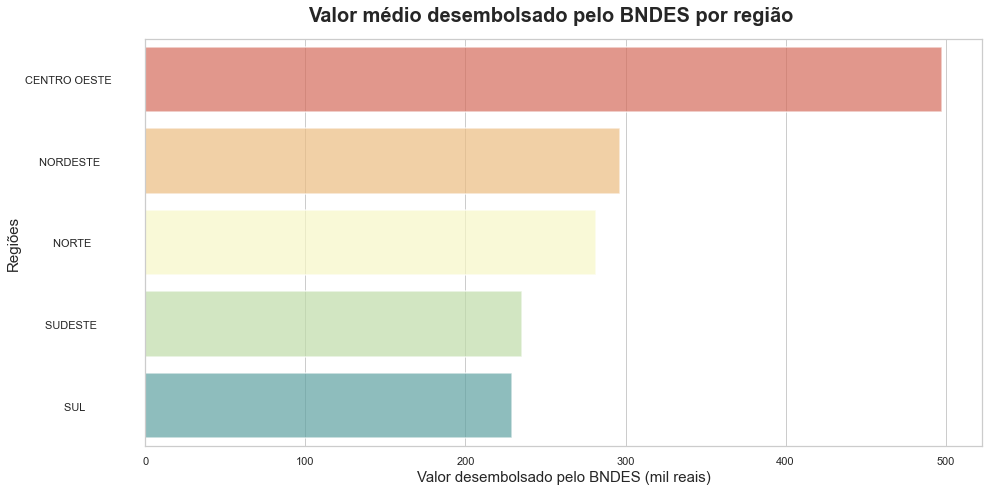

In [221]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize = (15,7.5))

ax = sns.barplot(data = df_regiao, 
                x = df_regiao.desembolso_sum / (df_regiao.desembolso_count * 10 ** 3),
                y = df_regiao.regiao_br,
                palette = "Spectral",
                alpha = .7, 
                linewidth = 1.5,
                orient = 'h')

ax.set_xlabel('Valor desembolsado pelo BNDES (mil reais)', 
                  fontsize = 15, 
                  y = 0.2)
    
ax.set_ylabel('Regiões', 
                fontsize = 15, 
                y = 0.5)

fig.suptitle('Valor médio desembolsado pelo BNDES por região', 
                fontsize = 20, 
                fontweight = 'bold',
                y = 0.94);

plt.savefig('./plots/desembolso_medio_regiao.png', bbox_inches = 'tight', pad_inches = 0.1)


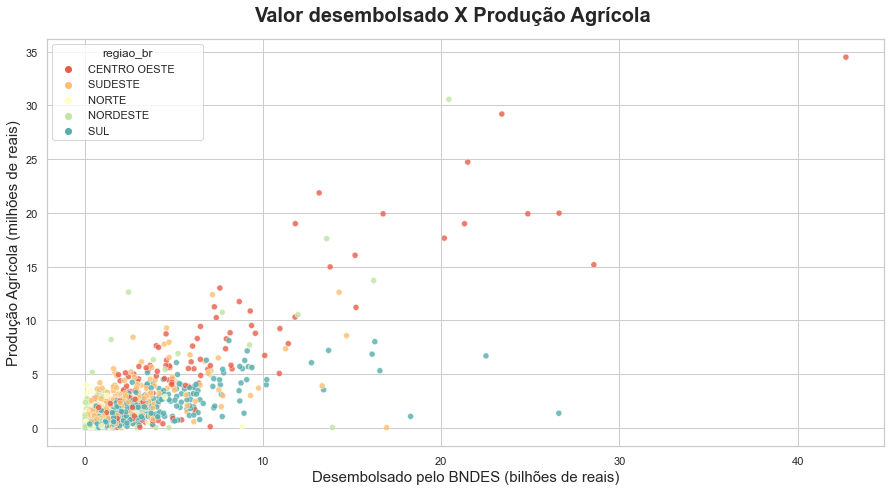

In [234]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize = (15,7.5))

ax = sns.scatterplot(x = df_municipio.desembolso_sum / (10 ** 9), 
                     y = df_municipio.valor_reais / (10 ** 6), 
                     hue=df_municipio.regiao_br, 
                     alpha=.8, 
                     palette= 'Spectral')

ax.set_xlabel('Desembolsado pelo BNDES (bilhões de reais)', 
                  fontsize = 15, 
                  y = 0.5,)
    
ax.set_ylabel('Produção Agrícola (milhões de reais)', 
                fontsize = 15, 
                y = 0.5)

fig.suptitle('Valor desembolsado X Produção Agrícola', 
                fontsize = 20, 
                fontweight = 'bold',
                y = 0.94)

plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

plt.savefig('./plots/desembolso_vs_prod_agricola.png', bbox_inches = 'tight', pad_inches = 0.1)

In [281]:
def corr_regiao(regiao):
  
    sns.set_theme(style="darkgrid")

    fig, ax = plt.subplots(figsize = (12,6))

    ax = sns.scatterplot(x = df_municipio.loc[df_municipio.regiao_br == regiao].desembolso_sum / (10 ** 9), 
                         y = df_municipio.loc[df_municipio.regiao_br == regiao].valor_reais / (10 ** 6),
                         alpha=.5, 
                         hue = df_municipio.loc[df_municipio.regiao_br == regiao].inovativo,
                         palette = {"Não": "#33FFBD",  'Sim': "#FF5733"})


    ax.legend(loc = 2, fancybox = True, title = 'TOP 10 Inovativos')


    ax.set_xlabel('Desembolsado pelo BNDES (bilhões de reais)', 
                    fontsize = 15, 
                    y = 0.5,)
    
    ax.set_ylabel('Produção Agrícola (milhões de reais)', 
                    fontsize = 15, 
                    y = 0.5,
                    x = 0.1)

    fig.suptitle(f'Valor desembolsado X Produção Agrícola no {str(regiao).title()}', 
                    fontsize = 20, 
                    fontweight = 'bold',
                    y = 0.98)

    plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='x')

    plt.savefig(f'./plots/desembolso_prod_agricola_{str(regiao).strip()}.png', bbox_inches = 'tight', pad_inches = 0.1)

interact(corr_regiao, regiao = df_municipio.regiao_br.unique());


interactive(children=(Dropdown(description='regiao', options=('CENTRO OESTE        ', 'SUDESTE             ', …

<function __main__.corr_regiao(regiao)>

In [280]:
def corr_razao(regiao):
  
    sns.set_theme(style="darkgrid")

    fig, ax = plt.subplots(figsize = (12,6))

    ax = sns.scatterplot(data = df_municipio.loc[df_municipio.regiao_br == regiao], 
                         x = df_municipio.loc[df_municipio.regiao_br == regiao].desembolso_sum / (10 ** 9), 
                         y = "razao",
                         hue = df_municipio.loc[df_municipio.regiao_br == regiao].inovativo,
                         palette = {'Sim': "#FF5733", "Não": "#33FFBD",  },
                         alpha=.5)

    ax.legend(loc = 4, fancybox = True, title = 'TOP 10 Inovativos')

    ax.set_xlabel('Desembolsado pelo BNDES (milhões de reais)', 
                    fontsize = 15, 
                    y = 0.5,)
    
    ax.set_ylabel('Razão Plantio\Colheita', 
                    fontsize = 15, 
                    y = 0.5,
                    x = 0.1)

    fig.suptitle(f'Valor desembolsado X Razão Plantio\Colheita no {str(regiao).title()}', 
                    fontsize = 20, 
                    fontweight = 'bold',
                    y = 0.98)

    plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='x')

    plt.savefig(f'./plots/desembolso_razao_{str(regiao).strip()}.png', bbox_inches = 'tight', pad_inches = 0.1)

interact(corr_razao, regiao = df_municipio.regiao_br.unique());

interactive(children=(Dropdown(description='regiao', options=('CENTRO OESTE        ', 'SUDESTE             ', …